# Outlier detection in time series using machine learning models
Notebook 04 modelling
___

### Table of Contents:
* [Introduction](#hading-1)
* [Train-validation split](#heading-2)
* [Model](#heading-3)
* [Model](#heading-4)
* [Model](#heading-5)
* [Model](#heading-6)
* [Forecast](#heading-7)

### Introduction

TODO

### Import libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
plt.rcParams.update({'font.size': 13})

In [3]:

def decomposition_df(df, column, frequency='MS',aggregation_method='sum', type='additive'):
    '''
    Process a dataframe to decompose its time series data and add trend, seasonal, residual, and trend+seasonal columns.
    
    Parameters:
    - df: pandas DataFrame containing the data to be processed
    - column: the column to be processed in the dataframe
    - frequency: the frequency of the decomposition, default monthly 
        - D - daily
        - h- hourly
        - W- weekly 

        look here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    -aggregation_method: the method of the decomposition, default sum
        -mean
        -min
        -max


    -type: the used model in the decomposition, default = additive
        - multiplicative 
    
    
    Returns:
    - df_Frequency: the processed DataFrame with additional columns
    '''
    aggregation_func = getattr(pd.DataFrame, aggregation_method)
    df_Frequency=df[[column]].resample(frequency).apply(aggregation_func)
    decompositon= seasonal_decompose(df_Frequency[column], model=type)


    df_Frequency['Trend'] = decompositon.trend
    df_Frequency['Seasonal'] = decompositon.seasonal
    df_Frequency['Noise'] = decompositon.resid
    df_Frequency['Trend+Seasonal'] = df_Frequency['Seasonal'] + df_Frequency['Trend']

    return df_Frequency

In [4]:
def data_loading_train_and_test_and_set_index(df_name, base_path = '../data/'):
    '''
    loads the dataframe df from the base_path and set_the 'Start' column as the index in datetime format.

    df_name: expect a df Name for example Prices_FRA_hourly
    base_path default: '../data/' 

    return Prices_FRA_hourly
    '''
    
    file_path1 = f"{base_path}{df_name}_train.csv"
    df1= pd.read_csv(file_path1)
    if 'Unnamed: 0' in df1.columns:
        df1['Start'] = pd.to_datetime(df1['Unnamed: 0'])
        df1 = df1.drop(columns = 'Unnamed: 0')
        df1 = df1.set_index('Start')
    else:
        df1['Start'] = pd.to_datetime(df1['Start'])
        df1 = df1.set_index('Start')

    file_path2 = f"{base_path}{df_name}_test.csv"
    df2= pd.read_csv(file_path2)
    if 'Unnamed: 0' in df2.columns:
        df2['Start'] = pd.to_datetime(df2['Unnamed: 0'])
        df2 = df2.drop(columns = 'Unnamed: 0')
        df2 = df2.set_index('Start')
    else:
        df2['Start'] = pd.to_datetime(df2['Start'])
        df2 = df2.set_index('Start')

    return df1, df2 

In [5]:
def resampler(df1, df2, frequency='h',aggregation_method='sum'):
        '''
        df1, df2 are the datasets
        frequency = h, W, Ms, D,
        aggregation_method = sum, mean
        '''
        df1 = df1.resample(frequency).apply(aggregation_method)
        df2 = df2.resample(frequency).apply(aggregation_method)
        return df1, df2

In [6]:
def train_validation_splitter(df, date = '2020-03-21 00:00:00'):
    '''
    takes a dataframe df and splits it at a custome date into df1, df2 as return
    '''
    df1 = df.loc[df.index < date]
    df2 = df.loc[df.index >= date]

    return df1, df2

In [7]:
def date_feature_creator(df):
    '''
    Create features out of the time series datetime index of a dataframe df:

    hour, dayofweek, dayofyear,month, quarter, year
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week #Monday = 0, Sunday = 6
    df['dayofyear'] = df.index.day_of_year #o to 365
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter 
    df['year'] = df.index.year

    return df

In [8]:
def add_seasonal_difference(df, column= 'Germany_Luxembourg_co2_adjusted'):
    '''
    creates lags from a target column column -
      use the lags of 364 days (to be equal divided by 7), 
    728 and 1092 days 
    
    '''

    target_map = df[column].to_dict()
    df['lag364'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag728'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag1092'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [9]:
TARGET = ['Germany_Luxembourg_co2_adjusted']

def Feature_target_seperator(df,features, target=TARGET):
    '''
    create two subsets with the target column and the feature columns
    
    '''
    dfX = df[features]
    dfy = df[target]
    return dfX, dfy

In [10]:
def trend_seasonal_decompostion(df, column = 'Germany_Luxembourg_co2_adjusted'):
    decompositon= seasonal_decompose(df[column], model='additive')

    df['Trend'] = decompositon.trend
    df['Seasonal'] = decompositon.seasonal
    df['Noise'] = decompositon.resid
    df['Trend+Seasonal'] = df['Seasonal'] + df['Trend']

    return df

In [11]:
def feature_scaler_StandardScaler(df, features):
    '''
    Apply a StandardScaler on the specified features inside a DataFrame
    and return the DataFrame with scaled features.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features (list): The list of column names to scale.
    
    Returns:
    pd.DataFrame: The DataFrame with scaled features.
    '''
    scaler = StandardScaler()
    
    df_not_features = df.drop(columns=features)
    features_to_scale = df[features]
    scaled_features = scaler.fit_transform(features_to_scale)

    
    scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=df.index)
    
    
    df_scaled = pd.concat([df_not_features, scaled_features_df], axis=1)
    
    return df_scaled

In [12]:
def feature_scaler_minmax(df, features):
    '''
    Apply a MinMaxScaler on the specified features inside a DataFrame
    and return the DataFrame with scaled features.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features (list): The list of column names to scale.
    
    Returns:
    pd.DataFrame: The DataFrame with scaled features.
    '''
    scaler = MinMaxScaler()
    
    df_not_features = df.drop(columns=features)
    features_to_scale = df[features]
    scaled_features = scaler.fit_transform(features_to_scale)

    
    scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=df.index)
    
    
    df_scaled = pd.concat([df_not_features, scaled_features_df], axis=1)
    
    return df_scaled

### Loading of the data 

In [13]:
Prices_train, Prices_test = data_loading_train_and_test_and_set_index('Prices')
Consumption_train, Consumption_test = data_loading_train_and_test_and_set_index('Consumption')
Generation_train, Generation_test = data_loading_train_and_test_and_set_index('Generation')
Export_Import_train, Export_Import_test = data_loading_train_and_test_and_set_index('Export_Import')

We transform our data set into hourly sections

In [14]:
Prices_train, Prices_test = resampler(Prices_train, Prices_test, frequency='h', aggregation_method='mean')
Consumption_train, Consumption_test = resampler(Consumption_train, Consumption_test, frequency='h', aggregation_method='mean')
Generation_train, Generation_test = resampler(Generation_train, Generation_test, frequency='h', aggregation_method='mean')
Export_Import_train, Export_Import_test = resampler(Export_Import_train, Export_Import_test, frequency='h', aggregation_method='mean')

We have to make sure, that there is no overlapping between the train and the test set. We therefore delete the first hour out of our test sets:

In [15]:
Consumption_test = Consumption_test.iloc[1:,:]
Prices_test = Prices_test.iloc[1:,:]
Generation_test = Generation_test.iloc[1:,:]
Export_Import_test = Export_Import_test.iloc[1:,:]

We create a train_df and a test_df with our features and our target Germany_Luxembourg_co2_adjusted

In [16]:
train_df = pd.concat([Prices_train[['Germany_Luxembourg_co2_adjusted', 'France_adjusted','Belgium_adjusted', 'Austria_adjusted', 'Switzerland_adjusted',
       'Czech_Republic_adjusted']], Consumption_train, Generation_train, Export_Import_train], axis=1)

In [17]:
test_df = pd.concat([Prices_test[['Germany_Luxembourg_co2_adjusted','France_adjusted','Belgium_adjusted', 'Austria_adjusted', 'Switzerland_adjusted',
       'Czech_Republic_adjusted']], Consumption_test, Generation_test, Export_Import_test], axis=1)

In [18]:
train_df_original = train_df.copy()
test_df_original =test_df.copy()

In [19]:
GLOABAL_FEATURES = ['Total_sum','France_adjusted', 'Belgium_adjusted','Switzerland_adjusted', 'Czech_Republic_adjusted',
       'Residual', 'Hydro', 'Biomass', 'Hydropower', 'Wind_offshore',
       'Wind_onshore', 'Photovoltaics', 'Other_renewable', 'Nuclear',
       'Lignite', 'Hard_coal', 'Fossil_gas', 'Hydro_pumped_storage',
       'Other_conventional', 'Generation_sum', 'Export_Import_sum',
       'Export_sum', 'Import_sum', 'Belgium_sum', 'France_sum', 'Poland_sum',
       'Austria_sum', 'Czech_Republic_sum', 'Switzerland_sum',
       'Remainder_sum']


# 'Austria_adjusted' was deleted because the value Austria was created in Notebook 01- out of the DE/AT/LU Price, which contains the target variable.

Scaling before we add temporal features (trend, seasonality, lags, dayofweek, etc.).

In [20]:
train_df = feature_scaler_minmax(train_df, GLOABAL_FEATURES)
test_df = feature_scaler_minmax(test_df, GLOABAL_FEATURES)

In [21]:
train_df = trend_seasonal_decompostion(train_df)
test_df = trend_seasonal_decompostion(test_df)

### Train-validation split <a class="anchor" id="heading-2"></a>

In [22]:
train_subset_df, validation_df = train_validation_splitter(train_df)

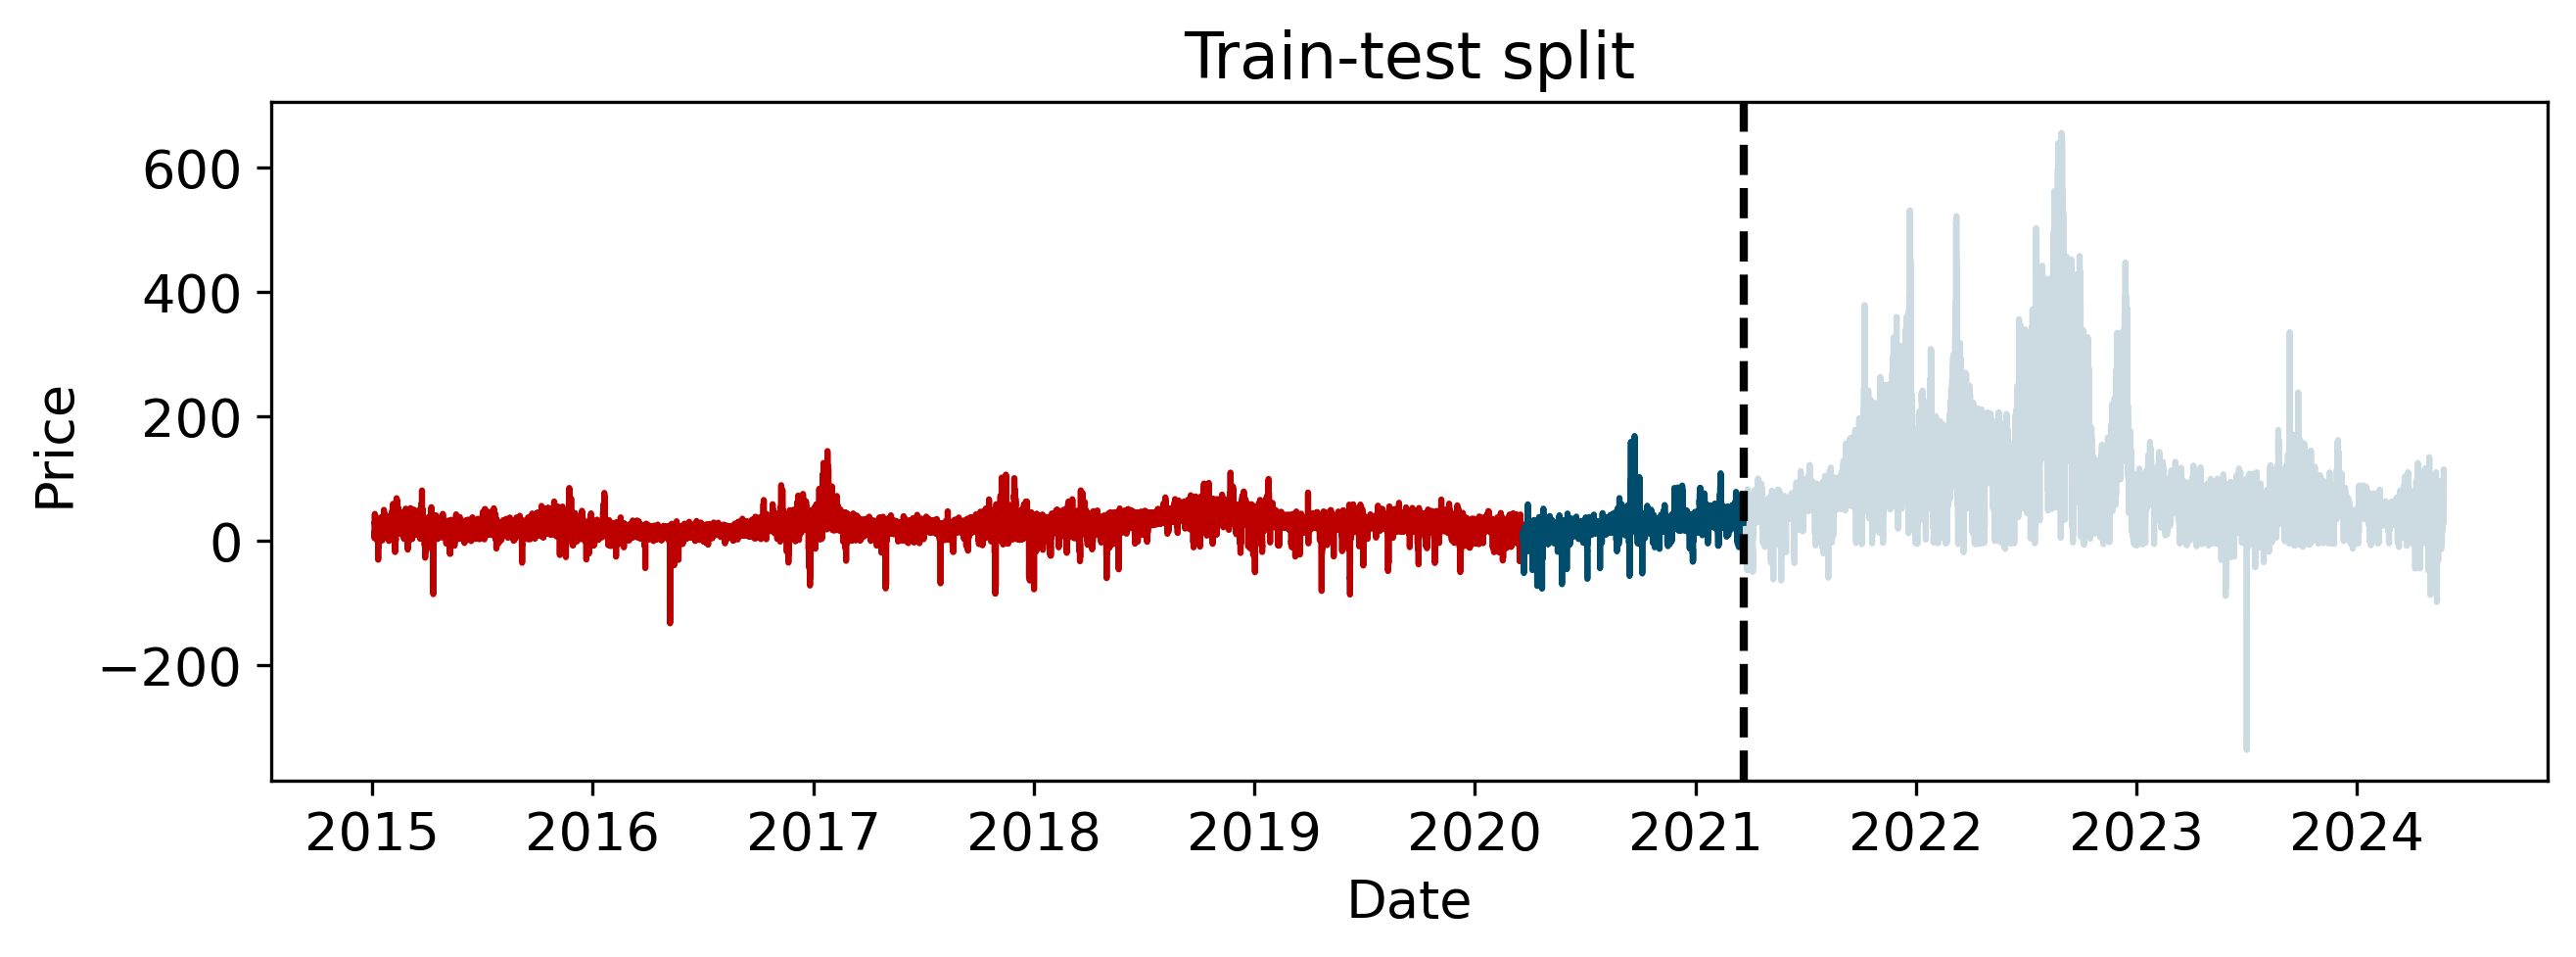

In [23]:
plt.figure(figsize = (10,3), dpi = 300)

plt.plot(train_subset_df['Germany_Luxembourg_co2_adjusted'], color = '#bc0000')
plt.plot(validation_df['Germany_Luxembourg_co2_adjusted'], color = '#004c6d')
plt.plot(test_df['Germany_Luxembourg_co2_adjusted'], color = '#004c6d', alpha = 0.2)
plt.axvline(test_df.index.min(), linewidth = 2, color = '#000000', linestyle = '--')
plt.title('Train-test split')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

My target is the column Germany_Luxembourg_adjusted_co2, this remains the same in all models, so we define this at the beginning

In [24]:
TARGET = ['Germany_Luxembourg_co2_adjusted']

In [25]:
train_subset_df = date_feature_creator(train_subset_df)
train_subset_df =add_seasonal_difference(train_subset_df)
validation_df = date_feature_creator(validation_df)
validation_df =add_seasonal_difference(validation_df)

In [26]:
test_df = date_feature_creator(test_df)
test_df =add_seasonal_difference(test_df)

### SARIMAX <a class="anchor" id="heading-3"></a>

In [27]:
FEATURES_1 = ['hour','dayofweek', 'dayofyear', 'month', 'quarter', 'year', 'Seasonal']

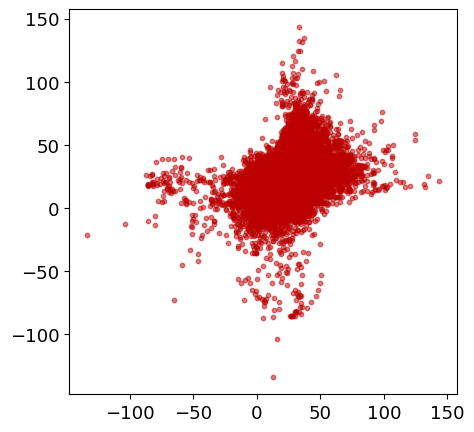

In [28]:
plt.figure(figsize=(5,5), dpi=100)
plt.scatter(x=train_subset_df[TARGET],y=train_subset_df['lag364'], color='#bc0000', s= 10, alpha=0.5)
plt.show()

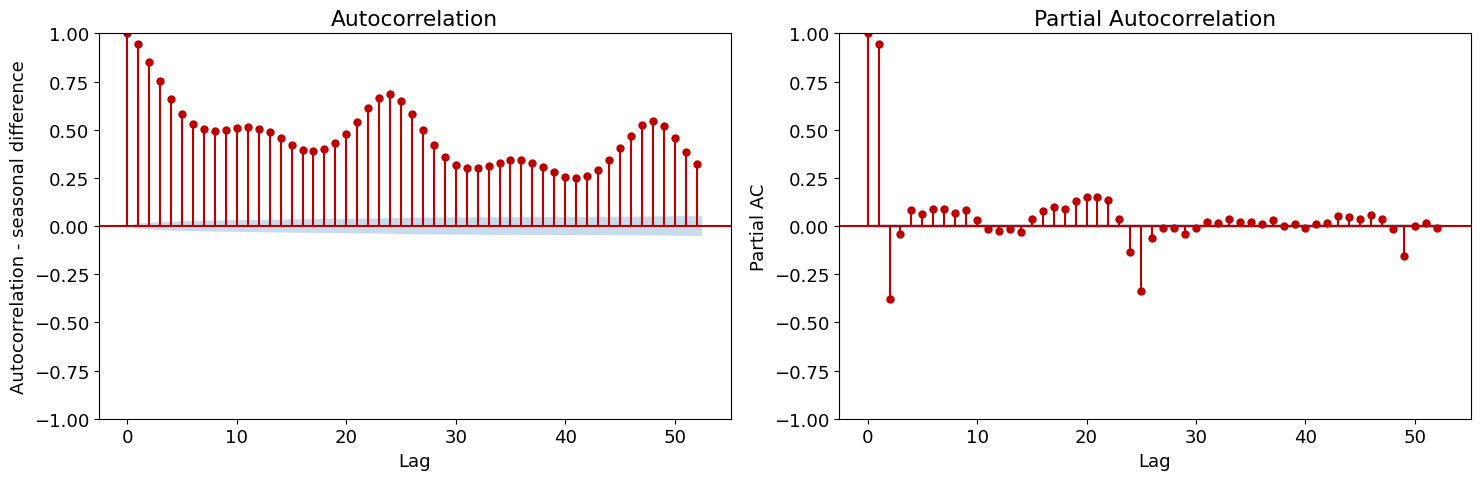

In [29]:

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# autocorrelation
plot_acf(train_subset_df['lag364'].dropna(), lags=52, ax=axs[0], color= '#bc0000', vlines_kwargs={"colors": '#bc0000'})
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation - seasonal difference')

# Partial autocorreleation
plot_pacf(train_subset_df['lag364'].dropna(), lags=52, ax=axs[1], method='ywm', color= '#bc0000', vlines_kwargs={"colors": '#bc0000'})
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial AC')

plt.tight_layout()
plt.show()


In [30]:
p_param = 2

reg_model_1 = SARIMAX(train_subset_df[TARGET],
                    exog = train_subset_df[FEATURES_1],
                    order=(p_param, 1, 1),
                    trend="c")
model_1_fit = reg_model_1.fit(disp=0)

print(model_1_fit.summary())

c:\Users\BMidd\.conda\envs\capstone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\BMidd\.conda\envs\capstone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\BMidd\.conda\envs\capstone\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:     Germany_Luxembourg_co2_adjusted   No. Observations:                45648
Model:                            SARIMAX(2, 1, 1)   Log Likelihood             -124876.395
Date:                             Thu, 04 Jul 2024   AIC                         249776.790
Time:                                     02:01:57   BIC                         249881.535
Sample:                                 01-05-2015   HQIC                        249809.740
                                      - 03-20-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.005     -0.035      0.972      -0.011       0.011
hour           0.0029      

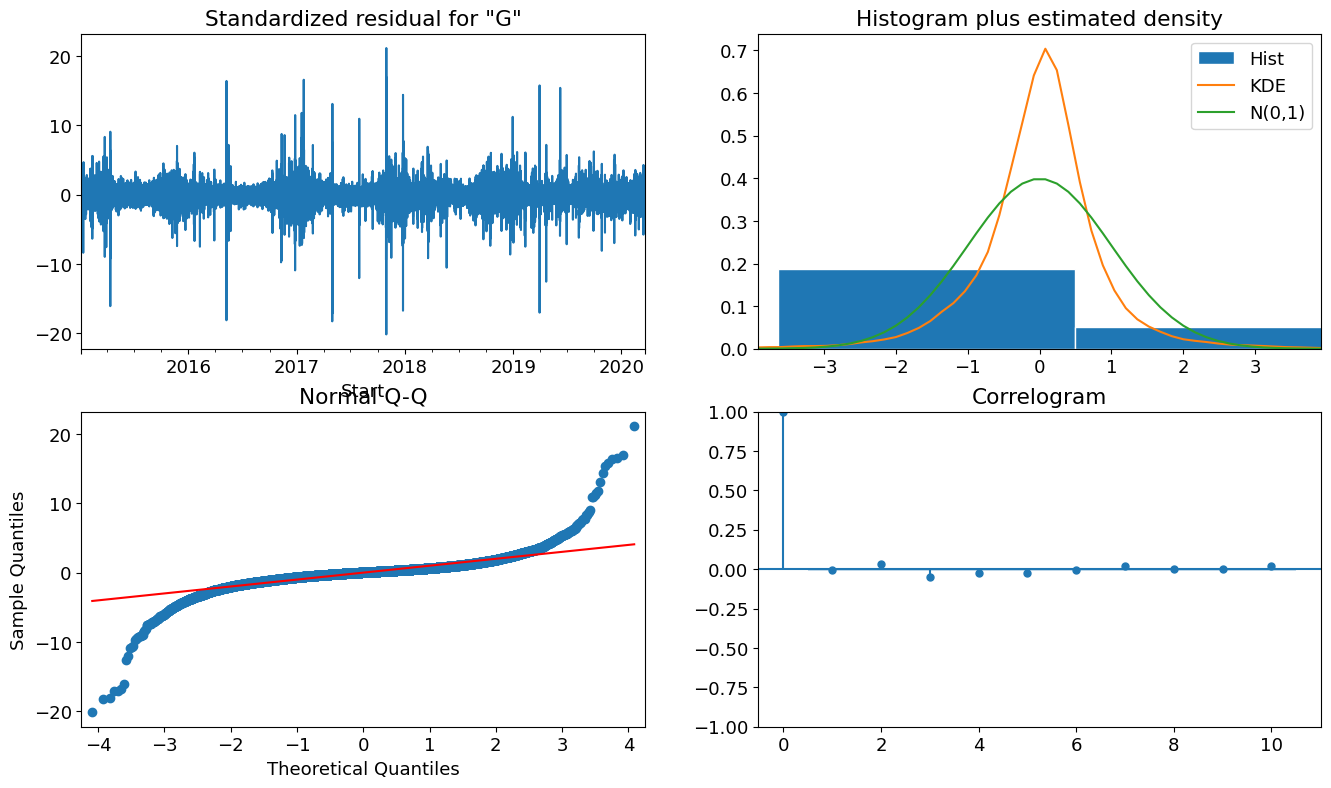

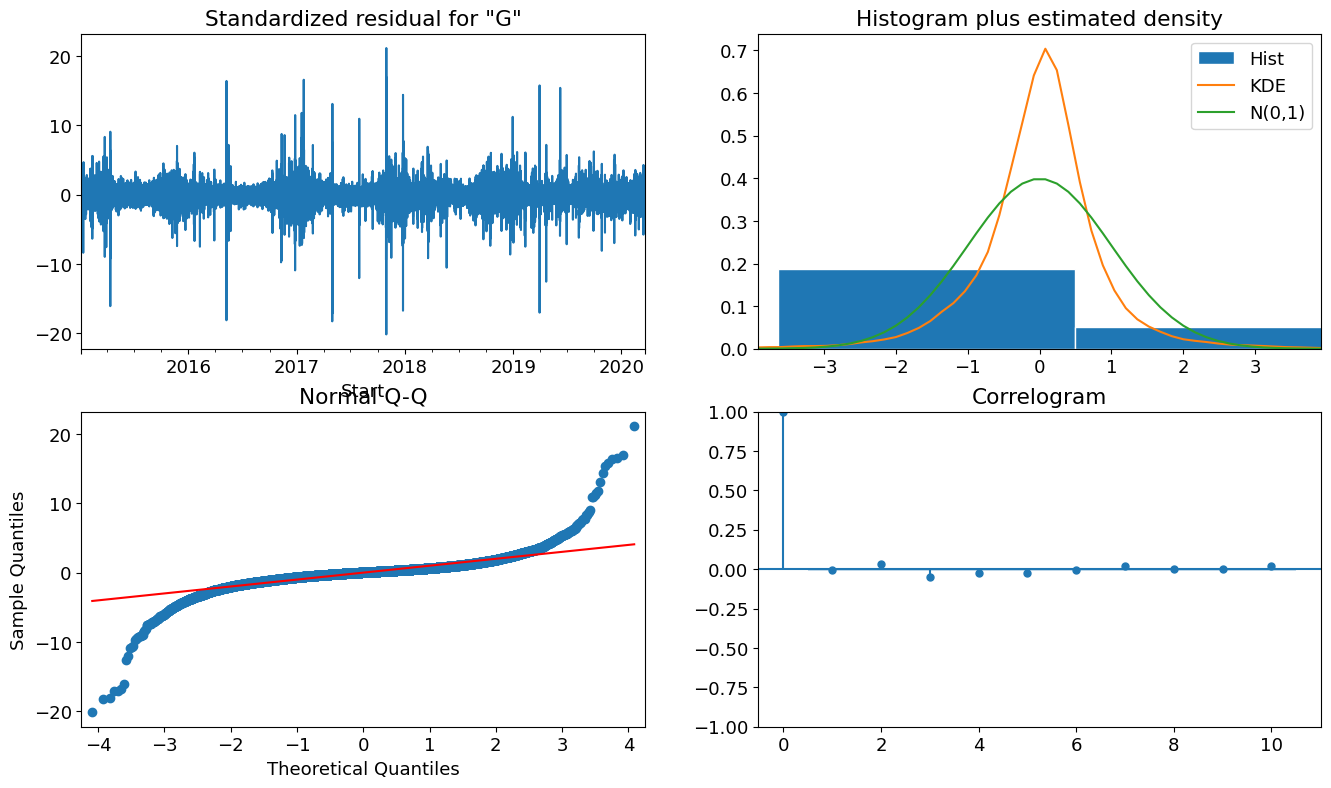

In [31]:
model_1_fit.plot_diagnostics(figsize=(16,9))

### Model 2: XGBBoost <a class="anchor" id="heading-4"></a>

This model will only consider price data within the zone Germany Luxembourg, therefore we created additional artificial features, XGBoost allows us, in contrast to SARIMAX, to also consider features like lags and trends that only have NaN values.

Feature choosing

In [32]:
FEATURES_2 = ['hour', 'dayofweek', 'dayofyear','quarter','year','month', 'Trend', 'Seasonal', 'Noise', 'lag364','lag728', 'lag1092']

In [33]:
X_train_subset_model_2, y_train_subset_model_2 = Feature_target_seperator(train_subset_df, target =TARGET, features = FEATURES_2)
X_validation_model_2, y_validation_model_2 = Feature_target_seperator(validation_df, target =TARGET, features = FEATURES_2)

In [34]:
reg_model_2= xgb.XGBRegressor(n_estimators = 6000, early_stopping_rounds=50, learning_rate = 0.01 )

reg_model_2.fit(X_train_subset_model_2, y_train_subset_model_2,
              eval_set = [(X_train_subset_model_2, y_train_subset_model_2),(X_validation_model_2, y_validation_model_2)],
              verbose =500)

[0]	validation_0-rmse:25.66593	validation_1-rmse:26.20531
[500]	validation_0-rmse:0.58627	validation_1-rmse:1.57673
[1000]	validation_0-rmse:0.39552	validation_1-rmse:1.45625
[1500]	validation_0-rmse:0.34176	validation_1-rmse:1.42664
[2000]	validation_0-rmse:0.30986	validation_1-rmse:1.41291
[2500]	validation_0-rmse:0.28150	validation_1-rmse:1.40173
[3000]	validation_0-rmse:0.26137	validation_1-rmse:1.39287
[3500]	validation_0-rmse:0.24569	validation_1-rmse:1.38765
[3723]	validation_0-rmse:0.23826	validation_1-rmse:1.38640


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=6000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

We see that our simple XGBBoost model performs very well within the train data period. This can be explained by the strong seasonality, the weak residuals and the relatively constant trend. We take a closer look to the feature importance..

<Figure size 640x480 with 0 Axes>

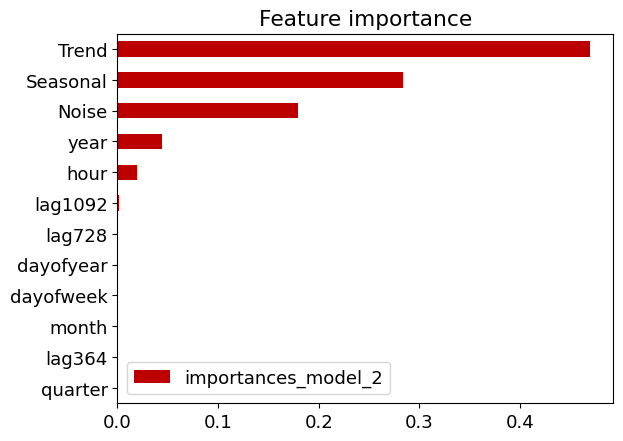

In [35]:
feature_importance_model_2 = pd.DataFrame(data =reg_model_2.feature_importances_, index = reg_model_2.feature_names_in_, columns = ['importances_model_2'])
plt.figure()
feature_importance_model_2.sort_values('importances_model_2').plot(kind='barh', title= 'Feature importance', color='#bc0000')
plt.show()

Trend, seasonality and residuals are the most important features. We have seen in the EDA that trend and residuals are no longer follow this pattern in our later target space, so we want to reduce their influence on our model, they are an effect, which is why trend and noise = residuals are removed. Seasonality is also not included in the models; as an alternative, artificial index features such as weekday, anniversary and quarter are incorporated. 
___

#### Model 2a XGBoost with optimized features

Therefore we train a nother XGBoots with the feature restriction mentioned above

In [36]:
FEATURES_2a = ['hour', 'dayofweek', 'dayofyear','quarter','year','month', 'lag364','lag728', 'lag1092']

In [37]:
X_train_subset_model_2a, y_train_subset_model_2a = Feature_target_seperator(train_subset_df, target =TARGET, features = FEATURES_2a)
X_validation_model_2a, y_validation_model_2a = Feature_target_seperator(validation_df, target =TARGET, features = FEATURES_2a)

In [38]:
reg_model_2a= xgb.XGBRegressor(n_estimators = 6000, early_stopping_rounds=50, learning_rate = 0.01 )

reg_model_2a.fit(X_train_subset_model_2a, y_train_subset_model_2a,
              eval_set = [(X_train_subset_model_2a, y_train_subset_model_2a),(X_validation_model_2a, y_validation_model_2a)],
              verbose =500)

[0]	validation_0-rmse:25.69736	validation_1-rmse:26.29691
[500]	validation_0-rmse:7.23098	validation_1-rmse:13.52321
[741]	validation_0-rmse:6.71160	validation_1-rmse:13.49072


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=6000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Figure size 640x480 with 0 Axes>

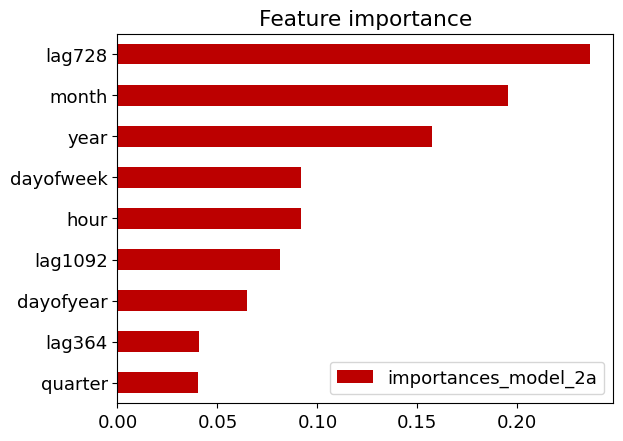

In [39]:
feature_importance_model_2a = pd.DataFrame(data =reg_model_2a.feature_importances_, index = reg_model_2a.feature_names_in_, columns = ['importances_model_2a'])
plt.figure()
feature_importance_model_2a.sort_values('importances_model_2a').plot(kind='barh', title= 'Feature importance', color='#bc0000')
plt.show()

We can see that the model is significantly worse than with the seasonal trend component, but we can ensure that this does not affect our difference later on. 

### Model 3: XGBBoost all Features <a class="anchor" id="heading-5"></a>

To improve performance, we extend our model with the other features from the Generation, Consumption, Import_Export dataframes and the prices from neighbouring regions. 

In [40]:
FEATURES_3 = FEATURES_2a + GLOABAL_FEATURES

In [41]:
X_train_subset_model_3, y_train_subset_model_3 = Feature_target_seperator(train_subset_df, target =TARGET, features = FEATURES_3)
X_validation_model_3, y_validation_model_3 = Feature_target_seperator(validation_df, target =TARGET, features = FEATURES_3)

In [42]:
reg_model_3= xgb.XGBRegressor(n_estimators = 10000, early_stopping_rounds=50, learning_rate = 0.01 )

reg_model_3.fit(X_train_subset_model_3, y_train_subset_model_3,
              eval_set = [(X_train_subset_model_3, y_train_subset_model_3),(X_validation_model_3, y_validation_model_3)],
              verbose =500)

[0]	validation_0-rmse:25.66901	validation_1-rmse:26.24061
[500]	validation_0-rmse:3.06472	validation_1-rmse:6.66429
[552]	validation_0-rmse:3.00316	validation_1-rmse:6.66486


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [43]:
feature_importance_model_3 = pd.DataFrame(data =reg_model_3.feature_importances_, index = reg_model_3.feature_names_in_, columns = ['importances_model_3'])


In [44]:
feature_importance_model_3 = feature_importance_model_3.sort_values('importances_model_3',ascending=True)

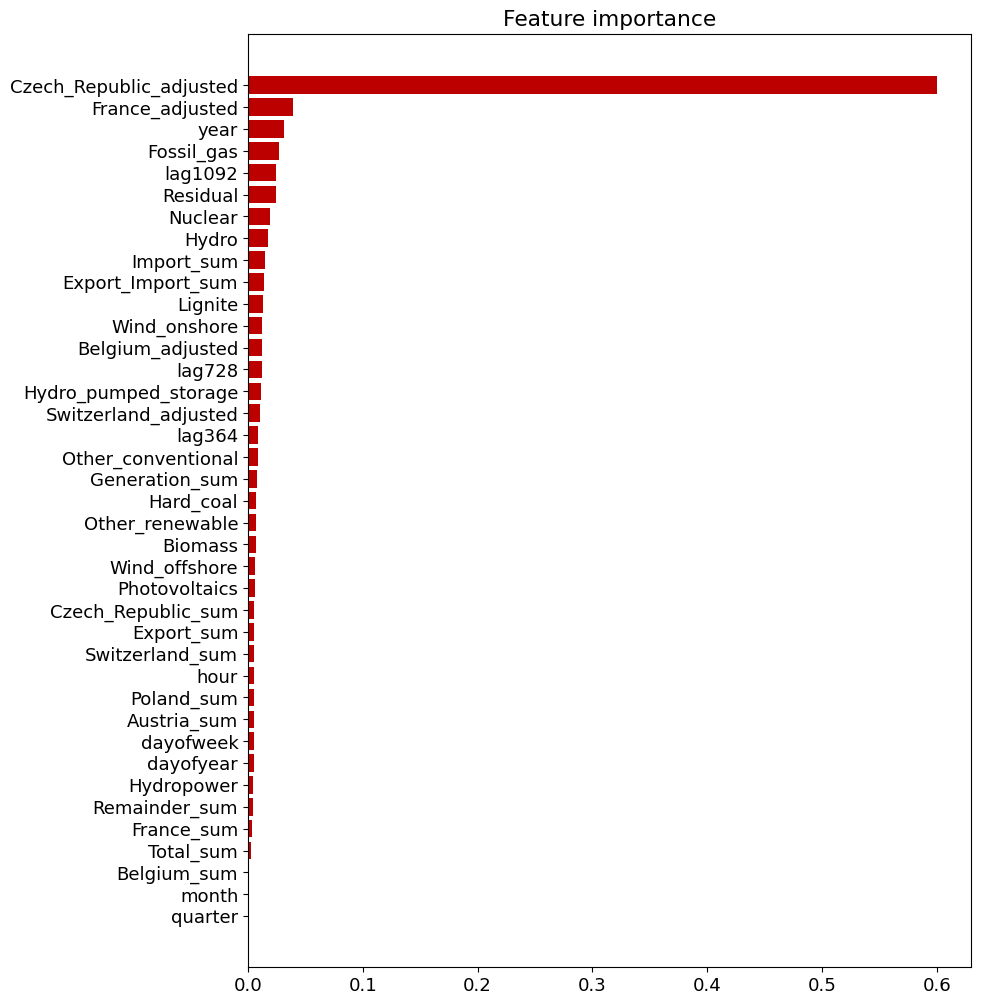

In [45]:
plt.figure(figsize = (10,10))
plt.barh(feature_importance_model_3.index, feature_importance_model_3['importances_model_3'], color='#bc0000')
plt.tight_layout()
plt.title('Feature importance')
plt.show()

We see that the price data of the neighbouring countries have a strong feature importance, this is explainable as the prices in all regions are subject to the same fluctuations, we will remove these as features from the model. 


#### Model 3a XGBoost with optimized features

We completely remove the prices of neighbouring countries. 

In [46]:
optimized_GLOBAL_FEATURES = ['Total_sum', 'Residual', 'Hydro', 'Biomass', 'Hydropower', 'Wind_offshore', 'Wind_onshore', 'Photovoltaics',
                            'Other_renewable', 'Nuclear', 'Lignite', 'Hard_coal', 'Fossil_gas', 'Hydro_pumped_storage', 'Other_conventional', 'Generation_sum',
                            'Export_Import_sum', 'Export_sum', 'Import_sum', 'Belgium_sum', 'France_sum', 'Poland_sum', 'Austria_sum', 'Czech_Republic_sum',
                            'Switzerland_sum', 'Remainder_sum']

In [47]:
FEATURES_3a = FEATURES_2a + optimized_GLOBAL_FEATURES

In [48]:
X_train_subset_model_3a, y_train_subset_model_3a = Feature_target_seperator(train_subset_df, target =TARGET, features = FEATURES_3a)
X_validation_model_3a, y_validation_model_3a = Feature_target_seperator(validation_df, target =TARGET, features = FEATURES_3a)

In [49]:
reg_model_3a= xgb.XGBRegressor(n_estimators = 10000, early_stopping_rounds=50, learning_rate = 0.01 )

reg_model_3a.fit(X_train_subset_model_3a, y_train_subset_model_3a,
              eval_set = [(X_train_subset_model_3a, y_train_subset_model_3a),(X_validation_model_3a, y_validation_model_3a)],
              verbose =500)

[0]	validation_0-rmse:25.67805	validation_1-rmse:26.26341
[500]	validation_0-rmse:3.82999	validation_1-rmse:10.37392
[694]	validation_0-rmse:3.56877	validation_1-rmse:10.30049


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [50]:
feature_importance_model_3a = pd.DataFrame(data =reg_model_3a.feature_importances_, index = reg_model_3a.feature_names_in_, columns = ['importances_model_3a'])
feature_importance_model_3a = feature_importance_model_3a.sort_values('importances_model_3a',ascending=True)


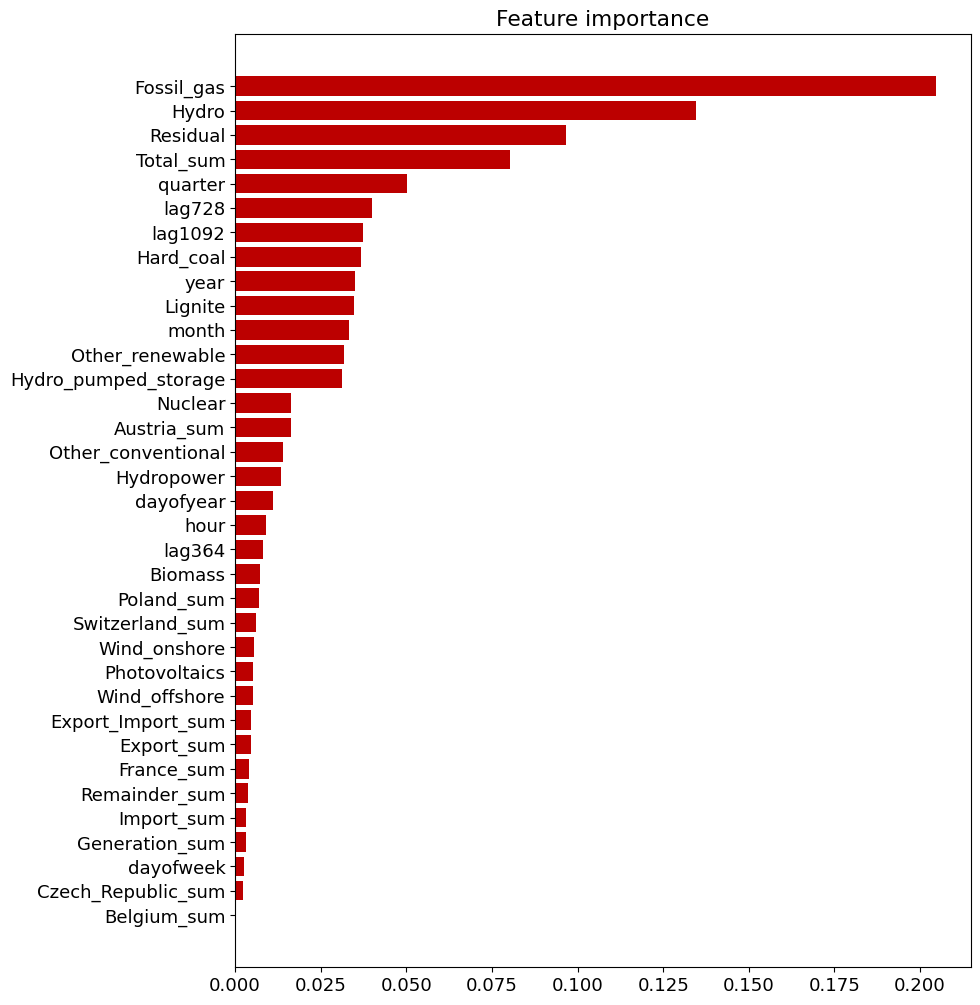

In [51]:
plt.figure(figsize = (10,10))
plt.barh(feature_importance_model_3a.index, feature_importance_model_3a['importances_model_3a'], color='#bc0000')
plt.tight_layout()
plt.title('Feature importance')
plt.show()

We see that the feature Fossil gas has the highest influence on the price, followed by hydro - in this case pumped storage power plants. This has to do with pricing and the use of these power plants in the electricity mix as peak load power plants and means that the model is taking the right approach. 


The further distribution and influence of the energy forms is also interesting. Renewables appear to have the least influence on the price, so they do not reduce the price

### Model 4: XGBBoost all Features <a class="anchor" id="heading-6"></a>

We therefore choose a cross-validation approach for a more robust model in order to reduce our dependency on the train-validation split and make our model more robust...

In [52]:
FEATURES_4 = FEATURES_3a

In [53]:
feature_importance_model_4 = pd.DataFrame(index = FEATURES_4)
tss = TimeSeriesSplit(n_splits=4, test_size=8760, gap=24) #8760h = 1 year = size of our validation
df = train_df.sort_index()


fold = 1
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    train = date_feature_creator(train)
    val = date_feature_creator(val)

    train = add_seasonal_difference(train)
    val = add_seasonal_difference(val)

    train = trend_seasonal_decompostion(train)
    val = trend_seasonal_decompostion(val)
    
    

    X_train = train[FEATURES_4]
    y_train = train[TARGET]

    X_val = val[FEATURES_4]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

    print(f"Fold {fold} completed with score: {score}")
    feature_importance_model_4[f'Fold_{fold}'] = reg.feature_importances_

    fold += 1


[02:06:23] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:21.53580	validation_1-rmse:23.84630
[100]	validation_0-rmse:10.05329	validation_1-rmse:12.68492
[200]	validation_0-rmse:6.41284	validation_1-rmse:9.01923
[300]	validation_0-rmse:5.24013	validation_1-rmse:7.73283
[400]	validation_0-rmse:4.73246	validation_1-rmse:7.41578
[500]	validation_0-rmse:4.44495	validation_1-rmse:7.32689
[600]	validation_0-rmse:4.27061	validation_1-rmse:7.23359
[700]	validation_0-rmse:4.15123	validation_1-rmse:7.14361
[800]	validation_0-rmse:4.07245	validation_1-rmse:7.14221
[845]	validation_0-rmse:4.03728	validation_1-rmse:7.14008
Fold 1 completed with score: 7.1342538541835365
[02:06:37] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rms

In [54]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 10.8552
Fold scores:[7.1342538541835365, 17.28456018445487, 7.847177485215595, 11.154801069897365]


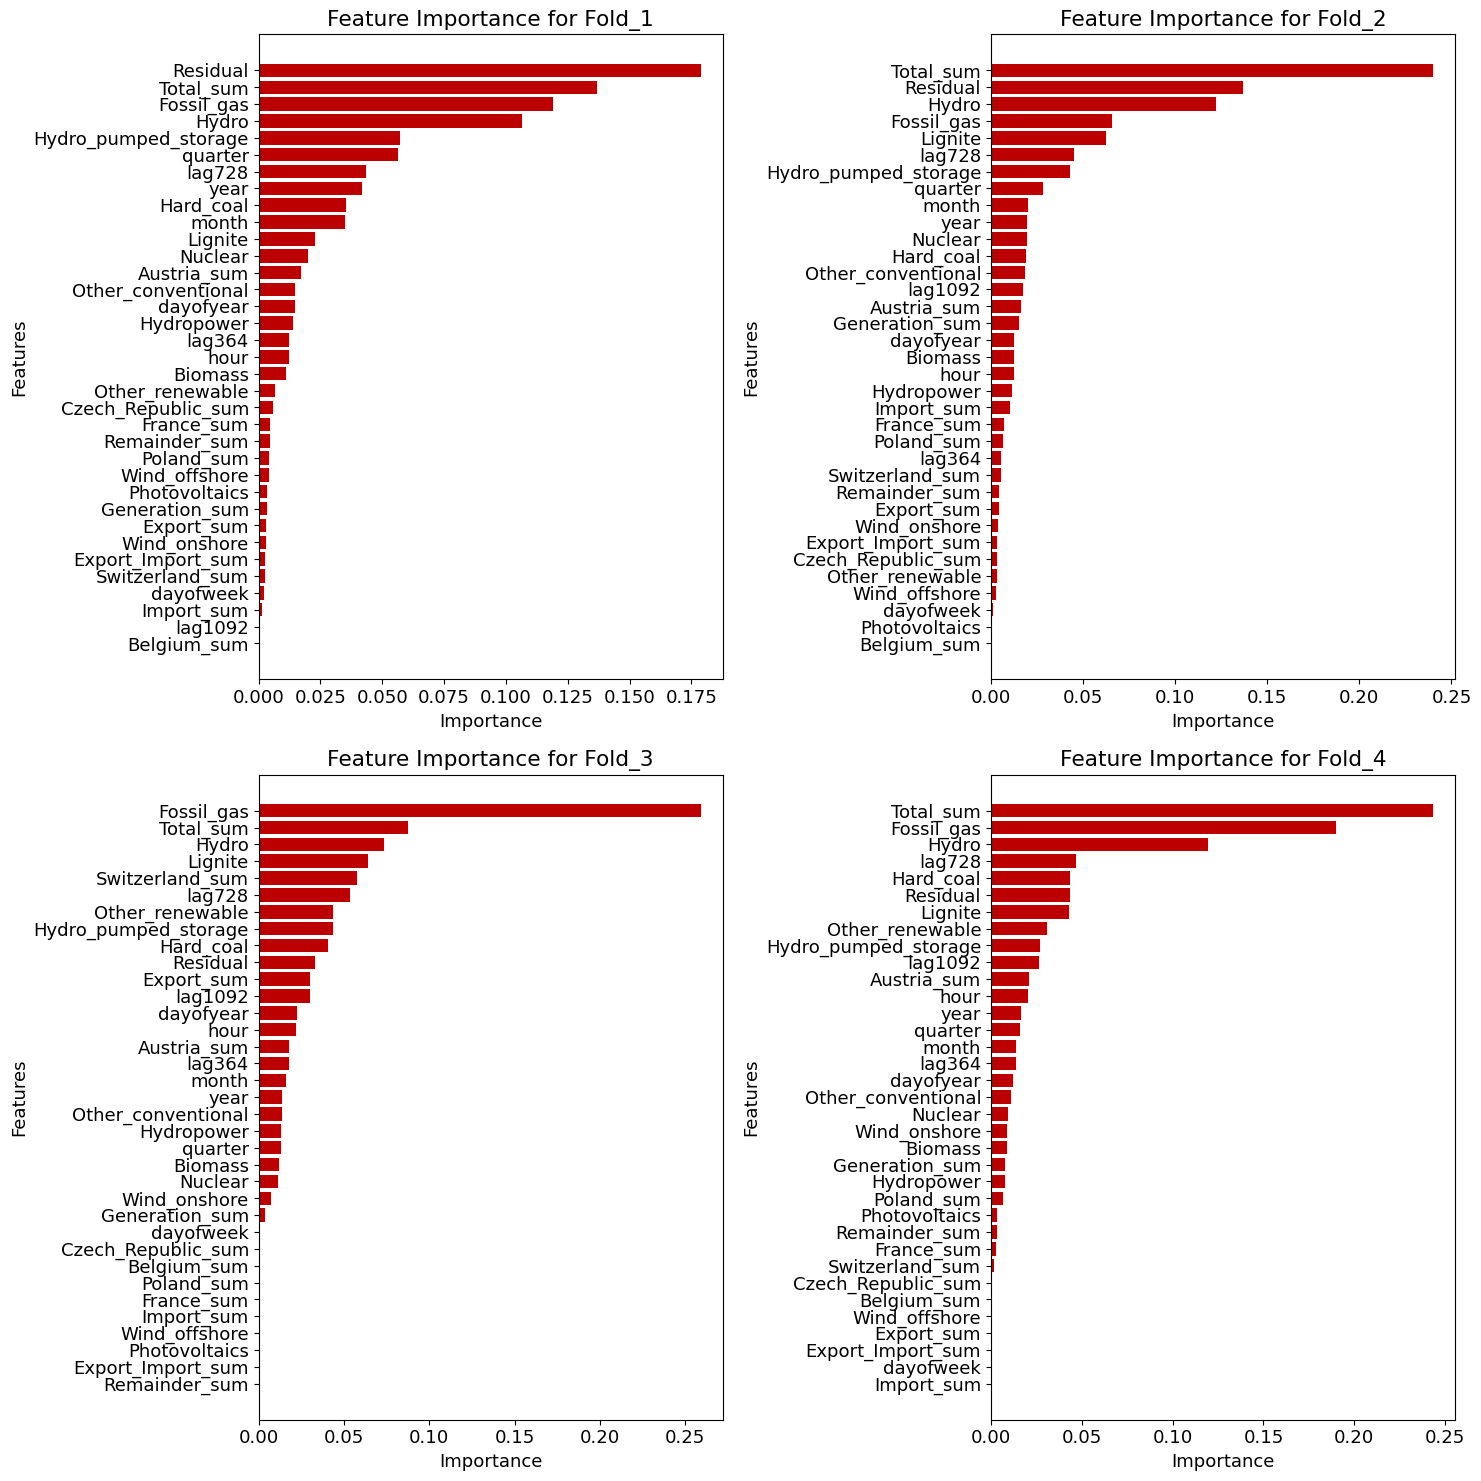

In [55]:
feature_importance_sorted = feature_importance_model_4.apply(lambda x: x.sort_values(ascending=True).index)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

for i, fold in enumerate(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4']):
    ax = axes[i//2, i%2]
    sorted_idx = feature_importance_sorted[fold]
    ax.barh(sorted_idx, feature_importance_model_4[fold].loc[sorted_idx], color='#bc0000')
    ax.set_title(f'Feature Importance for {fold}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')

plt.tight_layout()
plt.show()

### Forecast: XGBBoost all Features <a class="anchor" id="heading-7"></a>

We will now train our model one last time with the entire train room and then look ahead to the area of interest

In [56]:
train_df = date_feature_creator(train_df)
train_df = add_seasonal_difference(train_df)
train_df = trend_seasonal_decompostion(train_df)

In [57]:
X_all, y_all = Feature_target_seperator(train_df, FEATURES_4)

In [60]:
np.mean([845, 723, 312, 444]) #number of folds in cross-val to get an avg. when the model starts to overfit

581.0

In [62]:
reg_model_final = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=600, # we use the cal avg. as max estimators 581 = 600
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
reg_model_final.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[02:10:51] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:25.78346
[100]	validation_0-rmse:12.46138
[200]	validation_0-rmse:8.40806
[300]	validation_0-rmse:7.15370
[400]	validation_0-rmse:6.60621
[500]	validation_0-rmse:6.25131
[599]	validation_0-rmse:6.00796


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [63]:
feature_importance_model_final = pd.DataFrame(data =reg_model_final.feature_importances_, index = reg_model_final.feature_names_in_, columns = ['importances_model_final'])
feature_importance_model_final = feature_importance_model_final.sort_values('importances_model_final',ascending=True)


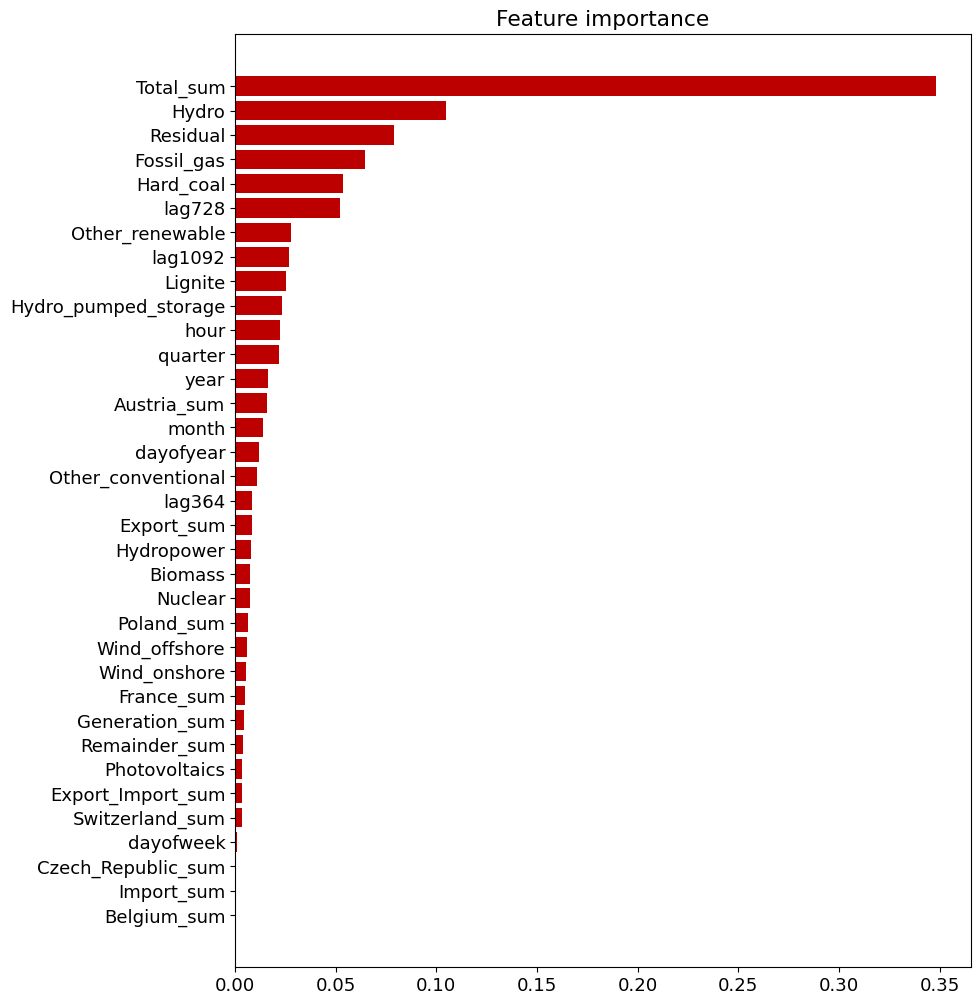

In [65]:
plt.figure(figsize = (10,10))
plt.barh(feature_importance_model_final.index, feature_importance_model_final['importances_model_final'], color='#bc0000')
plt.tight_layout()
plt.title('Feature importance')
plt.show()

Predict into test..

In [92]:
Prediction = test_df.copy()
Prediction['isTest'] = True
Train = train_df.copy()
Train['isTest'] = False
Prediction_area = pd.concat([Train, Prediction])
Prediction_area = date_feature_creator(Prediction_area)
Prediction_area = add_seasonal_difference(Prediction_area)
area_of_intrest = Prediction_area.query('isTest').copy()

make the prediction...

In [95]:
area_of_intrest['Predicted_price'] = reg_model_final.predict(area_of_intrest[FEATURES_4])

___
#### Conclusion / Next Steps

.....

___